# Introduction to coupling light into optical fibers

In high-contrast imaging we usually only consider the propagation of electric-fields in homogenous media, such as air or lenses. In this tutorial we will show how to work with optical fibers, which propagate a different set of mode bases. We start by importing the required libraries and defining some unit constants.

In [1]:
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt

um = 1e-6

Usually fibers are small and have compact modes. To couple efficiently into such fibers we need to focus the light onto the fiber face. Therefore we start by making a pupil that we can propagate to a focus.

In [2]:
num_pupil_pixels = 128
D_pupil = 1
pupil_grid = make_pupil_grid(num_pupil_pixels, D_pupil)

aperture = circular_aperture(D_pupil)(pupil_grid)

## Types of fibers
The standard fiber is a step-index fiber. A step-index fiber has a small core of high-refractive index surrounded by a cladding of a lower index. This allows for light to be trapped inside the core. In the geometrics optics limit, where the fiber core is many times larger than the wavelength, the trapping inside the fiber happens due to total internal reflection. This is shown in the figure below for two different rays.

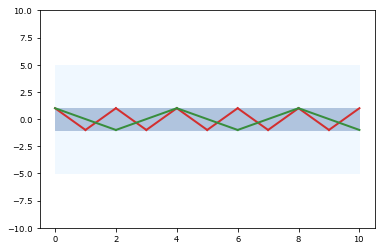

In [3]:
xmax = 10
xt = np.linspace(0, xmax)

plt.fill_between(xt, -5, 5, color='aliceblue')
plt.fill_between(xt, -1, 1, color='lightsteelblue')

x = np.linspace(0, 1)
for i in range(xmax):
    y = (2*(i%2)-1) * 2/(x.max()-x.min()) * (x-x.min()) - (2*(i%2)-1)
    plt.plot(x + i, y, 'C1', linewidth=2)

x = np.linspace(0, 2)
for i in range(5):
    y = (2*(i%2)-1) * 2/(x.max()-x.min()) * (x-x.min()) - (2*(i%2)-1)
    plt.plot(x + 2 * i, y, 'C2', linewidth=2)
    
plt.ylim([-10,10])
plt.show()

In the limit of small cores geometric optics does not work anymore and one needs to consider solving the Maxwell Equations. Due to the invariance of the fiber structure in the propagation direction we can solve the fiber propagation in terms of guided modes. This guided modes will propagate like plane waves but with a different field shape,
$$ E(\vec{r}, z)=\phi\left(\vec{r}\right) e^{i\beta z} $$
Here $\phi\left(\vec{r}\right)$ is the field distribution and $\beta$ is the propagation constant.
Due to linearity of the Maxwell equations we can use the principle of linear superposition when we have a mixture of modes,  
$$ E = \sum_n a_n \phi_n $$
In hcipy the mode solver for guided modes and propagation constants for step-index fibers has been implemented. Now let's look at some types of fibers.

In [4]:
multimode_fiber_core_radius = 25 * um
singlemode_fiber_core_radius = 2 * um
fiber_NA = 0.13
fiber_length = 10

multi_mode_fiber = StepIndexFiber(multimode_fiber_core_radius, fiber_NA, fiber_length)
single_mode_fiber = StepIndexFiber(singlemode_fiber_core_radius, fiber_NA, fiber_length)

In this piece of code we created two fibers. A multi-mode fiber with a large core and a single-mode fiber with a small core. Next to the core radius the numerical aperture is also necessary to fully specify the step-index fiber. Finally the length of the fiber is also needed for the propagation. The StepIndexFiber class will calculate the modes on the fly when they are needed, so it is not necessry to initialize it with a wavelength or a grid.

## Coupling into fibers
We will now create our grid on which we will evaluate the modes. The minimal diameter we need for the grid is 50 $\mu$m because the multi-mode fiber core radius is 25 $\mu$m. To sample all features of the modes we need to have sufficient resolution, which is roughly 2 pixels per wavelength. In this case we will use 128 pixels. With the focal plane setup we can setup the propagator too, we choose the focal length in such a way that we match the numerical aperture of the fiber.

In [5]:
num_focal_pixels = 128
D_focus = 2.1 * multimode_fiber_core_radius
focal_grid = make_pupil_grid(num_focal_pixels, D_focus)

focal_length = D_pupil/(2 * fiber_NA)
propagator = FraunhoferPropagator(pupil_grid, focal_grid, focal_length=focal_length)

To propagate the light through the fiber is as easy as propagating through any of the other propagators. You just call the forward method with the wavefront as parameter. In the code below we propagate a circular aperture to the focal plane and then propagate it through both the multi-mode and single-mode fiber.

Multi-mode fiber throughput 0.976168
Single-mode fiber throughput 0.717799


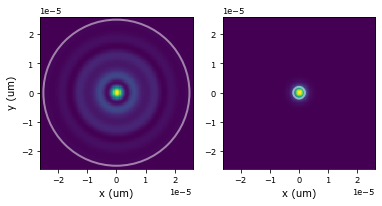

In [6]:
wavelength = 1 * um
wf = Wavefront(aperture, wavelength)
wf.total_power = 1

wf_foc = propagator(wf)

wf_mmf = multi_mode_fiber.forward(wf_foc)
wf_smf = single_mode_fiber.forward(wf_foc)

print("Multi-mode fiber throughput {:g}".format(wf_mmf.total_power))
print("Single-mode fiber throughput {:g}".format(wf_smf.total_power))

plt.subplot(1,2,1)
imshow_field(wf_mmf.power)

circ = plt.Circle((0, 0), multimode_fiber_core_radius, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
plt.gca().add_artist(circ)
plt.xlabel('x (um)')
plt.ylabel('y (um)')

plt.subplot(1,2,2)
imshow_field(wf_smf.power)
circ = plt.Circle((0, 0), singlemode_fiber_core_radius, edgecolor='white', fill=False, linewidth=2, alpha=0.5)
plt.gca().add_artist(circ)
plt.xlabel('x (um)')
plt.show()

The size of the fiber is shown by the white circle. We can see here that the output of both fibers is different. Because the multi-mode fiber supports more modes we can see a more complex output. This is also apparant in the throughput, the multi-mode fiber has a higher-throughput. The multi-mode fiber also has advantages when the source is moving due to vibration in your system. This is shown in the next section where the throughput as function of $\lambda / D$ is calculated.

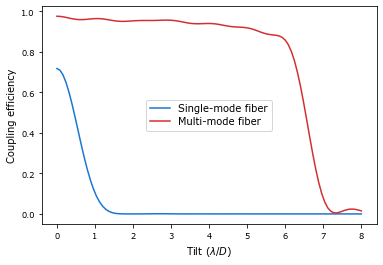

In [7]:
tilts = np.linspace(0, 8, 101)

smf_coupling = []
mmf_coupling = []
for tilt in tilts:
    wf = Wavefront(aperture * np.exp(1j * tilt * 2 * np.pi * pupil_grid.x), wavelength)
    wf.total_power = 1
    wf_foc = propagator(wf)
    
    wf_mmf = multi_mode_fiber.forward(wf_foc)
    mmf_coupling.append(wf_mmf.total_power)
    wf_smf = single_mode_fiber.forward(wf_foc)
    smf_coupling.append(wf_smf.total_power)

plt.plot(tilts, smf_coupling, label='Single-mode fiber')
plt.plot(tilts, mmf_coupling, label='Multi-mode fiber')
plt.xlabel(r'Tilt ($\lambda / D$)')
plt.ylabel('Coupling efficiency')
plt.legend()
plt.show()

## Fiber wavelength sensitivity

Because the multi-mode fiber contains many modes with different propagation constants there is a strong wavelength dependence of the fiber output. This is due to the beating pattern of different modes.

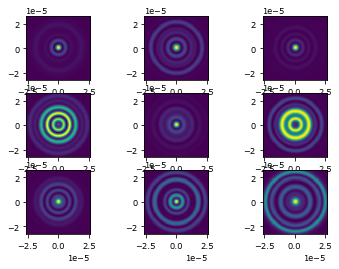

In [15]:
num_waves = 9
bandwidth = 0.01
wavelengths = wavelength * (1 + bandwidth * np.linspace(-1/2, 1/2, num_waves))

for wi, wave in enumerate(wavelengths):
    wf = Wavefront(aperture, wave)
    wf.total_power = 1
    wf_foc = propagator(wf)
    
    wf_mmf = multi_mode_fiber.forward(wf_foc)
    plt.subplot(3,3,wi+1)
    imshow_field(wf_mmf.power)
plt.show()

The coherence length of the input light determines how long fiber can be before the output start to decohere.